In [1]:
# --- 第1步：初始化与加载数据 ---
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers
from matplotlib import pyplot as plt

# 设置显示精度
pd.options.display.max_rows = 10
pd.options.display.float_format = "{:.1f}".format

# 加载训练集和测试集
train_df = pd.read_csv("https://download.mlcc.google.com/mledu-datasets/california_housing_train.csv")
test_df = pd.read_csv("https://download.mlcc.google.com/mledu-datasets/california_housing_test.csv")

# ⚡️ 预处理技巧：把房价单位变成“千美元”
# 这样模型处理 250.0 比处理 250000.0 容易得多
scale_factor = 1000.0
train_df["median_house_value"] /= scale_factor
test_df["median_house_value"] /= scale_factor

# 打乱训练集 (防止数据排序导致的偏差)
train_df = train_df.sample(frac=1).reset_index(drop=True)

print("✅ 数据加载完毕！")
print(f"训练集样本数: {len(train_df)}")
print(f"测试集样本数: {len(test_df)}")

✅ 数据加载完毕！
训练集样本数: 17000
测试集样本数: 3000


In [2]:
# --- 第2步：定义模型构建与绘图函数 (工具箱) ---

def build_model(my_inputs, my_outputs, my_learning_rate):
  """创建并编译一个标准的回归模型"""
  model = tf.keras.Model(inputs=my_inputs, outputs=my_outputs)
  model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=my_learning_rate),
                loss="mean_squared_error",
                metrics=[tf.keras.metrics.RootMeanSquaredError()])
  return model

def train_model(model, dataset, epochs, batch_size, label_name):
  """训练模型并返回 loss 曲线"""
  features = {name:np.array(value) for name, value in dataset.items()}
  label = np.array(features.pop(label_name))
  history = model.fit(x=features, y=label, batch_size=batch_size,
                      epochs=epochs, shuffle=True, verbose=0) # verbose=0 不刷屏
  epochs = history.epoch
  hist = pd.DataFrame(history.history)
  rmse = hist["root_mean_squared_error"]
  return epochs, rmse

def plot_the_loss_curve(epochs, rmse):
  """画 Loss 曲线"""
  plt.figure()
  plt.xlabel("Epoch")
  plt.ylabel("Root Mean Squared Error")
  plt.plot(epochs, rmse, label="Loss")
  plt.legend()
  plt.ylim([rmse.min()*0.94, rmse.max()*1.05])
  plt.show()

print("✅ 工具函数定义完成！")

✅ 工具函数定义完成！


切分点 (Boundaries): [32.0, 33.0, 34.0, 35.0, 36.0, 37.0, 38.0, 39.0, 40.0]


2026-01-15 10:57:56.352075: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M4 Pro
2026-01-15 10:57:56.352403: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 24.00 GB
2026-01-15 10:57:56.353239: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 8.88 GB
2026-01-15 10:57:56.353843: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2026-01-15 10:57:56.354534: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


🚀 开始训练分桶模型...


/Users/mike/miniconda3/envs/google_course/lib/python3.10/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: {'latitude': 'latitude'}
Received: inputs={'longitude': 'Tensor(shape=(100,))', 'latitude': 'Tensor(shape=(100,))', 'housing_median_age': 'Tensor(shape=(100,))', 'total_rooms': 'Tensor(shape=(100,))', 'total_bedrooms': 'Tensor(shape=(100,))', 'population': 'Tensor(shape=(100,))', 'households': 'Tensor(shape=(100,))', 'median_income': 'Tensor(shape=(100,))'}
  warnings.warn(msg)
2026-01-15 10:57:57.606816: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


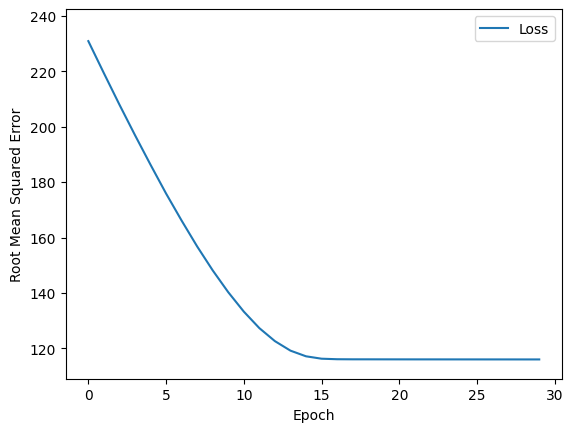

最终 RMSE: 116.01


In [3]:
# --- 第3步：把纬度切成 20 个桶 (Bucketing) ---

# 1. 定义输入
resolution_in_degrees = 1.0 # 每一度切一刀
# 创建一系列的切分点 (boundaries)
latitude_boundaries = list(np.arange(int(train_df['latitude'].min()), 
                                     int(train_df['latitude'].max()), 
                                     resolution_in_degrees))

print("切分点 (Boundaries):", latitude_boundaries)

# 2. 定义特征列
# 输入层：接收原始的浮点数
latitude = tf.keras.Input(shape=(1,), name='latitude')

# 分桶层：把浮点数变成 0, 1, 2, ... 这样的桶 ID
latitude_bucket_layer = tf.keras.layers.Discretization(bin_boundaries=latitude_boundaries)(latitude)

# 独热编码 (One-hot)：把桶 ID 变成向量，这样模型才能学
# output_mode='one_hot' 是关键
latitude_encoded = tf.keras.layers.IntegerLookup(vocabulary=list(range(len(latitude_boundaries) + 1)), 
                                                 output_mode='one_hot')(latitude_bucket_layer)

# 3. 连接输出层
# 这一步相当于为每一个“纬度桶”分配一个独立的权重
outputs = tf.keras.layers.Dense(units=1, name='output')(latitude_encoded)

# 4. 组装模型
model_buckets = build_model(my_inputs={'latitude': latitude}, 
                            my_outputs=outputs, 
                            my_learning_rate=0.04)

# 5. 训练！
print("🚀 开始训练分桶模型...")
epochs, rmse = train_model(model_buckets, train_df, 30, 100, 'median_house_value')

plot_the_loss_curve(epochs, rmse)
print(f"最终 RMSE: {rmse.iloc[-1]:.2f}")

🚀 启动 Embedding 深度模型...


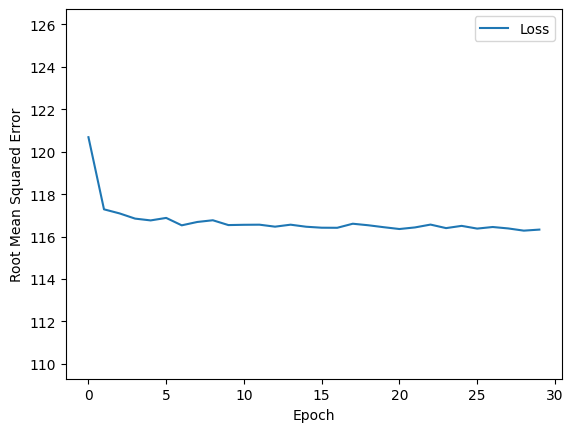

最终 RMSE: 116.33


In [8]:
# --- 第5步：终极进化 - 使用 Embedding 解决稀疏问题 ---

# 1. 依然保持高清分辨率
resolution_in_degrees = 0.04

# 重新计算切分点
latitude_boundaries = list(np.arange(int(train_df['latitude'].min()), 
                                     int(train_df['latitude'].max()), 
                                     resolution_in_degrees))
longitude_boundaries = list(np.arange(int(train_df['longitude'].min()), 
                                      int(train_df['longitude'].max()), 
                                      resolution_in_degrees))

# 定义输入
latitude = tf.keras.Input(shape=(1,), name='latitude')
longitude = tf.keras.Input(shape=(1,), name='longitude')

# 分桶
lat_bucket_layer = tf.keras.layers.Discretization(bin_boundaries=latitude_boundaries)(latitude)
lon_bucket_layer = tf.keras.layers.Discretization(bin_boundaries=longitude_boundaries)(longitude)

# ⚡️ 核心修改 1：output_mode 改成 'int'
# 我们不再要 One-hot (那个太稀疏了)，我们要整数索引，方便喂给 Embedding
crossed_feature = tf.keras.layers.HashedCrossing(
    num_bins=65000, 
    output_mode='int'  # <--- 注意这里改了！
)([lat_bucket_layer, lon_bucket_layer])

# ⚡️ 核心修改 2：加入 Embedding 层
# input_dim=65000: 有多少个格子
# output_dim=10: 把每个格子压缩成 10 个数字的向量 (这个数字可以调，10-50 都行)
embedding_layer = tf.keras.layers.Embedding(input_dim=65000, output_dim=10)(crossed_feature)

# ⚡️ 核心修改 3：Flatten
# Embedding 出来是立体的数据，要压扁才能连接到 Dense 层
flatten_layer = tf.keras.layers.Flatten()(embedding_layer)

# ⚡️ 核心修改 4：加个 Dense 层让它更聪明一点
dense_layer = tf.keras.layers.Dense(units=32, activation='relu')(flatten_layer)

# 输出
outputs = tf.keras.layers.Dense(units=1, name='output')(dense_layer)

# 组装
model_embedding = build_model(
    my_inputs={'latitude': latitude, 'longitude': longitude}, 
    my_outputs=outputs, 
    my_learning_rate=0.04 # 学习率保持不变
)

# 训练
print(f"🚀 启动 Embedding 深度模型...")
# 這次跑 30 轮就够了，Embedding 学得很快
epochs, rmse = train_model(model_embedding, train_df, 30, 100, 'median_house_value')

plot_the_loss_curve(epochs, rmse)
print(f"最终 RMSE: {rmse.iloc[-1]:.2f}")

In [9]:
# --- 修正 1：升级模型引擎 (使用 Adam) ---

def build_model(my_inputs, my_outputs, my_learning_rate):
  model = tf.keras.Model(inputs=my_inputs, outputs=my_outputs)
  # ⚡️ 关键修改：把 RMSprop 换成 Adam，它跑深度学习更稳
  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=my_learning_rate),
                loss="mean_squared_error",
                metrics=[tf.keras.metrics.RootMeanSquaredError()])
  return model

print("✅ 模型构建函数已升级为 Adam 版本！")

✅ 模型构建函数已升级为 Adam 版本！


🚀 启动 Embedding 模型 (LR=0.001, Epochs=70)...


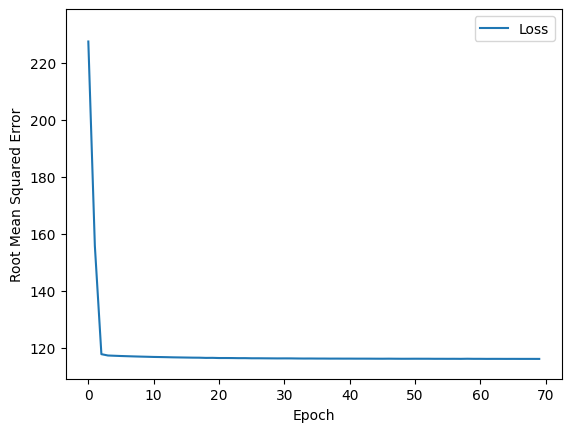

最终 RMSE: 116.03


In [10]:
# --- 修正 2：用“绣花针”耐心训练 ---

# 保持高清分辨率
resolution_in_degrees = 0.04

# 重新计算切分点
latitude_boundaries = list(np.arange(int(train_df['latitude'].min()), 
                                     int(train_df['latitude'].max()), 
                                     resolution_in_degrees))
longitude_boundaries = list(np.arange(int(train_df['longitude'].min()), 
                                      int(train_df['longitude'].max()), 
                                      resolution_in_degrees))

# 输入
latitude = tf.keras.Input(shape=(1,), name='latitude')
longitude = tf.keras.Input(shape=(1,), name='longitude')

# 分桶
lat_bucket_layer = tf.keras.layers.Discretization(bin_boundaries=latitude_boundaries)(latitude)
lon_bucket_layer = tf.keras.layers.Discretization(bin_boundaries=longitude_boundaries)(longitude)

# Cross + Embedding
crossed_feature = tf.keras.layers.HashedCrossing(num_bins=65000, output_mode='int')([lat_bucket_layer, lon_bucket_layer])
embedding_layer = tf.keras.layers.Embedding(input_dim=65000, output_dim=10)(crossed_feature) # 压缩成10维向量

# 深度网络结构
flatten_layer = tf.keras.layers.Flatten()(embedding_layer)
dense_layer = tf.keras.layers.Dense(units=32, activation='relu')(flatten_layer) # 32个神经元
outputs = tf.keras.layers.Dense(units=1, name='output')(dense_layer)

# 组装 (注意学习率！)
model_embedding = build_model(
    my_inputs={'latitude': latitude, 'longitude': longitude}, 
    my_outputs=outputs, 
    my_learning_rate=0.001 # ⚡️ 关键修改：从 0.04 降到 0.001
)

# 训练
print(f"🚀 启动 Embedding 模型 (LR=0.001, Epochs=70)...")
epochs, rmse = train_model(model_embedding, train_df, 70, 100, 'median_house_value')

plot_the_loss_curve(epochs, rmse)
print(f"最终 RMSE: {rmse.iloc[-1]:.2f}")

🚀 启动核动力 DNN 模型 (Adam, LR=0.01)...


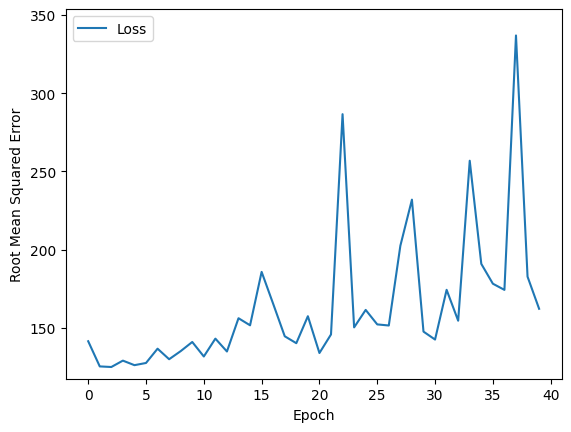

🏁 最终 RMSE: 162.12


In [11]:
# --- 💀 终极方案：现代深度神经网络 (No Bucketing, Just Deep Learning) ---

# 1. 准备数据：直接用原始的经纬度，不要切格子了！
# 我们只需要做一个 Z-Score 归一化，这是深度学习的“餐前洗手”
train_df_norm = train_df.copy()
test_df_norm = test_df.copy()

# 计算均值和标准差
lat_mean = train_df['latitude'].mean()
lat_std = train_df['latitude'].std()
lon_mean = train_df['longitude'].mean()
lon_std = train_df['longitude'].std()

# 执行归一化：(x - mean) / std
# 这样经纬度就会变成 -1.5, 0.5 这种模型最爱吃的数据
train_df_norm['latitude'] = (train_df['latitude'] - lat_mean) / lat_std
train_df_norm['longitude'] = (train_df['longitude'] - lon_mean) / lon_std

# 2. 定义输入
# 直接接收 2 个浮点数
inputs = {
    'latitude': tf.keras.Input(shape=(1,), name='latitude'),
    'longitude': tf.keras.Input(shape=(1,), name='longitude')
}

# 3. 把经纬度拼起来
concatenated_inputs = tf.keras.layers.Concatenate()(list(inputs.values()))

# 4. 搭建一个强力的神经网络 (MLP)
# 第一层：64 个神经元，用 ReLU 激活函数 (学会非线性地形)
x = tf.keras.layers.Dense(64, activation='relu')(concatenated_inputs)
# 第二层：32 个神经元 (提取核心特征)
x = tf.keras.layers.Dense(32, activation='relu')(x)
# 输出层
outputs = tf.keras.layers.Dense(1, name='output')(x)

# 5. 组装模型 (使用 Adam 优化器)
model_dnn = tf.keras.Model(inputs=inputs, outputs=outputs)
model_dnn.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
                  loss="mean_squared_error",
                  metrics=[tf.keras.metrics.RootMeanSquaredError()])

# 6. 训练！
print(f"🚀 启动核动力 DNN 模型 (Adam, LR=0.01)...")
epochs, rmse = train_model(model_dnn, train_df_norm, 40, 100, 'median_house_value')

plot_the_loss_curve(epochs, rmse)
print(f"🏁 最终 RMSE: {rmse.iloc[-1]:.2f}")

🐢 启动龟速稳健模式 (LR=0.0001)...


100%|██████████| 100/100 [03:10<00:00,  1.91s/epoch, loss=1.26e+4, root_mean_squared_error=112]


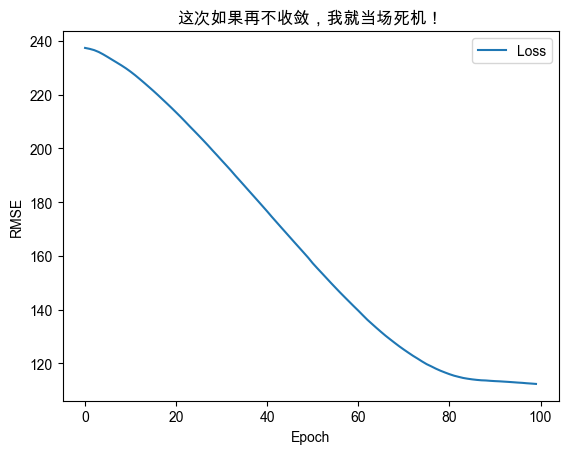

🏁 最终 RMSE: 112.39


In [14]:
# --- 🏳️ 最后的尊严：龟速稳健版 DNN (修复版) ---
import numpy as np # 确保 numpy 被导入
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers
from tqdm.keras import TqdmCallback

# 1. 修复中文乱码
plt.rcParams['font.sans-serif'] = ['Arial Unicode MS'] 
plt.rcParams['axes.unicode_minus'] = False 

# 2. 准备数据
inputs = {
    'latitude': tf.keras.Input(shape=(1,), name='latitude'),
    'longitude': tf.keras.Input(shape=(1,), name='longitude')
}

# 3. 使用 Keras 自带的标准化层
norm_layer = tf.keras.layers.Normalization(axis=-1)

# 🛠️ 关键修复：加了 .to_numpy()，把 DataFrame 变成纯数组
# 这样 Keras 就不会报错说找不到 input_shape 了
norm_layer.adapt(train_df[['latitude', 'longitude']].to_numpy())

# 拼接输入并标准化
concatenated = layers.Concatenate()(list(inputs.values()))
normalized_input = norm_layer(concatenated)

# 4. 网络结构
x = layers.Dense(64, activation='relu')(normalized_input)
x = layers.Dense(32, activation='relu')(x)
outputs = layers.Dense(1, name='output')(x)

model_final = tf.keras.Model(inputs=inputs, outputs=outputs)

# 5. 编译：学习率 0.0001 (龟速)
model_final.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                    loss="mean_squared_error",
                    metrics=[tf.keras.metrics.RootMeanSquaredError()])

# 6. 训练
print("🐢 启动龟速稳健模式 (LR=0.0001)...")
history = model_final.fit(
    x={
        'latitude': train_df['latitude'], 
        'longitude': train_df['longitude']
    },
    y=train_df['median_house_value'],
    batch_size=64,
    epochs=100,
    verbose=0,
    callbacks=[TqdmCallback(verbose=1)]
)

# 7. 见证时刻
rmse_list = history.history["root_mean_squared_error"]
plt.figure()
plt.xlabel("Epoch")
plt.ylabel("RMSE")
plt.plot(history.epoch, rmse_list, label="Loss")
plt.title("这次如果再不收敛，我就当场死机！")
plt.legend()
plt.show()

print(f"🏁 最终 RMSE: {rmse_list[-1]:.2f}")

🎨 正在绘制 AI 眼中的加州房价地图...
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step 


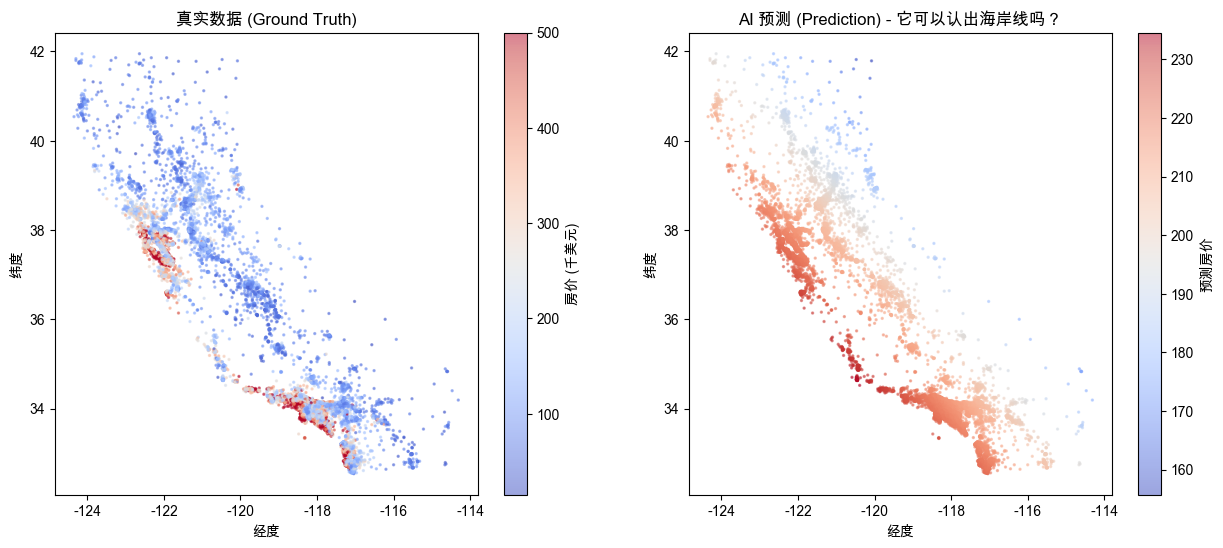

: 

In [ ]:
# --- 🗺️ 终极验收：AI 眼中的加州 ---
import matplotlib.pyplot as plt

# 1. 让刚才那个“龟速模型”预测一下训练集
print("🎨 正在绘制 AI 眼中的加州房价地图...")
predictions = model_final.predict(
    {'latitude': train_df['latitude'], 'longitude': train_df['longitude']},
    batch_size=1024,
    verbose=1
)

# 2. 准备画布
plt.figure(figsize=(15, 6))

# --- 左图：真实的加州房价 ---
plt.subplot(1, 2, 1)
plt.title("真实数据 (Ground Truth)")
plt.scatter(train_df['longitude'], train_df['latitude'], 
            c=train_df['median_house_value'], 
            cmap='coolwarm', s=2, alpha=0.5)
plt.colorbar(label='房价 (千美元)')
plt.xlabel("经度")
plt.ylabel("纬度")

# --- 右图：AI 预测的房价 ---
plt.subplot(1, 2, 2)
plt.title("AI 预测 (Prediction) - 它可以认出海岸线吗？")
plt.scatter(train_df['longitude'], train_df['latitude'], 
            c=predictions, 
            cmap='coolwarm', s=2, alpha=0.5)
plt.colorbar(label='预测房价')
plt.xlabel("经度")
plt.ylabel("纬度")

plt.show()